In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import datetime
from os.path import isfile, join

import time_hist, time_hist2

from geospacepy import omnireader


In [2]:
def NewellCF_calc(v,bz,by):
    # v expected in km/s
    # b's expected in nT    
    NCF = np.zeros_like(v)
    NCF.fill(np.nan)
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = .001
    #Caculate clock angle (theta_c = t_c)
    tc = np.arctan2(by,bztemp)
    neg_tc = bt*np.cos(tc)*bz < 0 
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    return NCF

In [3]:
# Function to find nearest indice in array (works with datetimes) - written for use with omnireader
def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))



### Read in DMSP data (1987 & 2010)

In [4]:
# files = ['/Users/ryanmcgranaghan/Documents/DMSPdata/full1987_reducedDB.csv',
#          '/Users/ryanmcgranaghan/Documents/DMSPdata/full2010_reducedDB.csv']
# data_1987 = pd.read_csv(files[0])
# data_2010 = pd.read_csv(files[1])

files = '/Users/ryanmcgranaghan/Documents/DMSPdata/full1987_reducedDB.csv'
# files = '/Users/ryanmcgranaghan/Documents/DMSPdata/full2010_reducedDB.csv'
data = pd.read_csv(files)

# data = pd.concat([data_1987,data_2010])

data.memory_usage()

Index                         80
datetime                 1088456
SC_AACGM_LAT             1088456
SC_AACGM_LTIME           1088456
ELE_TOTAL_ENERGY_FLUX    1088456
ELE_AVG_ENERGY           1088456
spacecraft number        1088456
dtype: int64

In [5]:
data.describe()


,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_AVG_ENERGY,spacecraft number
count,136057.000000,136057.000000,1.360570e+05,136057.000000,136057.000000
mean,64.808411,12.388266,1.286964e+11,2285.415039,6.972335
std,11.849308,7.641034,2.829850e+12,5135.011728,0.712212
min,45.000761,0.131909,1.038321e+05,30.000000,6.000000
25%,54.500914,5.698075,1.225595e+08,115.195926,6.000000
50%,65.344288,9.192773,4.743413e+08,256.688949,7.000000
75%,74.562285,20.165414,1.822298e+10,1371.688445,7.000000
max,89.107641,23.885717,4.374404e+14,30000.002000,8.000000


### Calculate rest of input DMSP data
1. DOY, UT, magnetic local times to periodic values




In [6]:
%%time

# Calculate doy and UT from datetime
ut = []
for d in range(len(data)):
    dt_now = (pd.to_datetime( data['datetime'][d] ))
    ut.append( (dt_now - dt_now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds() )
    
    
day_of_year = [pd.to_datetime(data['datetime'].iloc[d]).timetuple().tm_yday for d in range(len(data))]



data['sin_ut'] = [np.sin(2*np.pi*x/365.) for x in ut]
data['cos_ut'] = [np.cos(2*np.pi*x/365.) for x in ut]

data['sin_doy'] = [np.sin(2*np.pi*x/365.) for x in day_of_year]
data['cos_doy'] = [np.cos(2*np.pi*x/365.) for x in day_of_year]

data['sin_SC_AACGM_LTIME'] = [np.sin(2*np.pi*x/365.) for x in data.SC_AACGM_LTIME]
data['cos_SC_AACGM_LTIME'] = [np.cos(2*np.pi*x/365.) for x in data.SC_AACGM_LTIME]






CPU times: user 39.2 s, sys: 80.9 ms, total: 39.3 s
Wall time: 39.3 s


In [7]:
data.head()

,datetime,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_AVG_ENERGY,spacecraft number,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME
0,1987-01-01 00:14:00,81.839536,1.569204,3.742381e+09,218.059529,6,0.948362,-0.317191,0.017213,0.999852,0.027009,0.999635
1,1987-01-01 00:15:00,82.631612,9.749691,3.813348e+08,149.822024,6,0.213521,-0.976938,0.017213,0.999852,0.167046,0.985949
2,1987-01-01 00:16:00,82.278648,22.644955,1.804845e+08,146.822469,6,-0.729558,-0.683919,0.017213,0.999852,0.380017,0.924979
3,1987-01-01 00:17:00,80.902347,21.426555,1.735597e+08,182.665476,6,-0.961130,0.276097,0.017213,0.999852,0.360535,0.932746
4,1987-01-01 00:18:00,78.862610,20.581410,9.091227e+07,147.767233,6,-0.255353,0.966848,0.017213,0.999852,0.346927,0.937892


In [8]:
# Separate by spacecraft
f06_df = data[data['spacecraft number']==6]
f07_df = data[data['spacecraft number']==7]
f08_df = data[data['spacecraft number']==8]
# f16_df = data[data['spacecraft number']==16]
# f17_df = data[data['spacecraft number']==17]
# f18_df = data[data['spacecraft number']==18]




In [9]:
f06_df.index = pd.DatetimeIndex( f06_df['datetime'] )
f07_df.index = pd.DatetimeIndex( f07_df['datetime'] )
f08_df.index = pd.DatetimeIndex( f08_df['datetime'] )
# f16_df.index = pd.DatetimeIndex( f16_df['datetime'] )
# f17_df.index = pd.DatetimeIndex( f17_df['datetime'] )
# f18_df.index = pd.DatetimeIndex( f18_df['datetime'] )




In [10]:
f06_df.drop(['datetime','spacecraft number'], axis=1, inplace=True)
f07_df.drop(['datetime','spacecraft number'], axis=1, inplace=True)
f08_df.drop(['datetime','spacecraft number'], axis=1, inplace=True)
# f16_df.drop(['datetime','spacecraft number'], axis=1, inplace=True)
# f17_df.drop(['datetime','spacecraft number'], axis=1, inplace=True)
# f18_df.drop(['datetime','spacecraft number'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Pad DMSP data for every minute of the year


In [12]:
f06_df.head(10)
# f16_df.head(10)

,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_AVG_ENERGY,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME
datetime,,,,,,,,,,
1987-01-01 00:14:00,81.839536,1.569204,3.742381e+09,218.059529,0.948362,-0.317191,0.017213,0.999852,0.027009,0.999635
1987-01-01 00:15:00,82.631612,9.749691,3.813348e+08,149.822024,0.213521,-0.976938,0.017213,0.999852,0.167046,0.985949
1987-01-01 00:16:00,82.278648,22.644955,1.804845e+08,146.822469,-0.729558,-0.683919,0.017213,0.999852,0.380017,0.924979
1987-01-01 00:17:00,80.902347,21.426555,1.735597e+08,182.665476,-0.961130,0.276097,0.017213,0.999852,0.360535,0.932746
1987-01-01 00:18:00,78.862610,20.581410,9.091227e+07,147.767233,-0.255353,0.966848,0.017213,0.999852,0.346927,0.937892
1987-01-01 00:19:00,76.445275,20.010450,6.060774e+07,163.922790,0.699458,0.714673,0.017213,0.999852,0.337692,0.941257
1987-01-01 00:20:00,73.806310,19.611503,2.449536e+10,264.848857,0.972118,-0.234491,0.017213,0.999852,0.331220,0.943553
1987-01-01 00:21:00,71.023057,19.318463,1.015881e+11,781.244867,0.296713,-0.954967,0.017213,0.999852,0.326456,0.945212
1987-01-01 00:22:00,68.134932,19.092737,2.064459e+10,735.350060,-0.668064,-0.744104,0.017213,0.999852,0.322781,0.946474


In [13]:
minutes_date_range = pd.date_range('1/1/87', '1/1/88', closed='left', freq='min')
f06_df_new = f06_df.reindex(minutes_date_range)
f07_df_new = f07_df.reindex(minutes_date_range)
f08_df_new = f08_df.reindex(minutes_date_range)

# minutes_date_range = pd.date_range('1/1/10', '1/1/11', closed='left', freq='min')
# f16_df_new = f16_df.reindex(minutes_date_range)
# f17_df_new = f17_df.reindex(minutes_date_range)
# f18_df_new = f18_df.reindex(minutes_date_range)





In [14]:
f06_df_new.head(25)
# f16_df_new.head(25)

,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_AVG_ENERGY,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME
1987-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Collate solar wind data
1. Get OMNI interval
2. Get data over interval
    - Bz, By, Bx
    - F107
    - etc.
3. Calculate the derived parameters
    - Time histories (needs to be developed)
       --> (@-6 hours, -5 hours, -3 hours, -1 hour, -45 minutes, -30 minutes, -15 minutes, -10 minutes, -5 minutes)
          - These need to be averages



### Generate solar wind data over full year

In [16]:
%%time 

datetime_start = datetime.datetime(1987,1,1)
# datetime_start = datetime.datetime(2010,1,1)

t_start = datetime_start - datetime.timedelta(1)
t_end = datetime_start + datetime.timedelta(365) + datetime.timedelta(minutes = 10)
omniInt = omnireader.omni_interval(t_start,t_end,'5min', cdf_or_txt = 'txt')
omniInt_1hr = omnireader.omni_interval(t_start,t_end,'hourly', cdf_or_txt = 'txt')
   
# Get solar wind 5-minute data
epochs = omniInt['Epoch'] #time array for omni 5min data
Bx,By,Bz,AE,SymH = omniInt['BX_GSE'],omniInt['BY_GSM'],omniInt['BZ_GSM'],omniInt['AE_INDEX'], omniInt['SYM_H']
vsw,psw = omniInt['flow_speed'], omniInt['Pressure']
borovsky_reader = omnireader.borovsky(omniInt)
borovsky = borovsky_reader()

newell = NewellCF_calc(vsw, Bz, By)
    
epochs_1hr = omniInt_1hr['Epoch'] #datetime timestamps
F107,Kp = omniInt_1hr['F10_INDEX'],omniInt_1hr['KP']



Created interval between 1986-12-31 and 1988-01-01, cadence 5min, start index 104832, end index 2
Created interval between 1986-12-31 and 1988-01-01, cadence hourly, start index 8736, end index 1
Applying transform Hourly Kp*10 -> Kp to omni hourly variable KP
CPU times: user 13.9 s, sys: 910 ms, total: 14.8 s
Wall time: 14.8 s


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


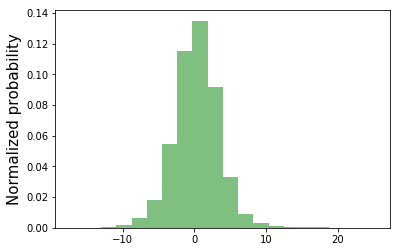

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdat
import matplotlib.mlab as mlab

fig = plt.figure()
# fig.set_size_inches(8,10)
plt.hist(Bz[Bz<500], 20, normed=1, facecolor='green', alpha=0.5)
plt.ylabel('Normalized probability', fontsize=15)#, labelpad=-30)
plt.show()

### Pad SW data for every minute of the year and generate SW time histories



In [18]:
%%time

idx = [0,len(Bz)]
SW_df = pd.DataFrame(data = np.column_stack([epochs[idx[0]:idx[1]],Bz[idx[0]:idx[1]],By[idx[0]:idx[1]],Bx[idx[0]:idx[1]],AE[idx[0]:idx[1]],SymH[idx[0]:idx[1]],vsw[idx[0]:idx[1]],psw[idx[0]:idx[1]],borovsky[idx[0]:idx[1]],newell[idx[0]:idx[1]]]),
                     columns=['epochs','Bz','By','Bx','AE','SymH','vsw','psw','borovsky','newell'])

SW_df.index = pd.DatetimeIndex( SW_df['epochs'] )
SW_df.drop( ['epochs'], axis=1, inplace=True)

SW_df = time_hist2.time_history(SW_df)

CPU times: user 4min 35s, sys: 1.11 s, total: 4min 36s
Wall time: 4min 36s


In [ ]:
# SW_df.to_csv('/Users/ryanmcgranaghan/Desktop/SW_df.csv')

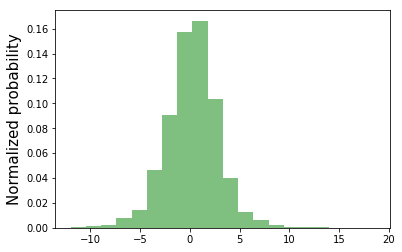

In [19]:
fig = plt.figure()
# fig.set_size_inches(8,10)
plt.hist(SW_df['Bz_6hr'][SW_df['Bz_6hr']<500], 20, normed=1, facecolor='green', alpha=0.5)
plt.ylabel('Normalized probability', fontsize=15)#, labelpad=-30)
plt.show()

In [20]:
SW_df.head()

,Bz,By,Bx,AE,SymH,vsw,psw,borovsky,newell,Bz_6hr,...,newell_1min,Bz_5min,By_5min,Bx_5min,AE_5min,SymH_5min,vsw_5min,psw_5min,borovsky_5min,newell_5min
epochs,,,,,,,,,,,,,,,,,,,,,
1986-12-31 00:00:00,9999.99,9999.99,9999.99,86,-14,99999.9,NaN,1.17162e+16,2.09529e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-12-31 00:05:00,9999.99,9999.99,9999.99,91,-13,99999.9,NaN,1.17162e+16,2.09529e+08,NaN,...,NaN,9999.99,9999.99,9999.99,86.0,-14.0,99999.9,NaN,1.171622e+16,2.095289e+08
1986-12-31 00:10:00,9999.99,9999.99,9999.99,86,-14,99999.9,NaN,1.17162e+16,2.09529e+08,NaN,...,2.095289e+08,9999.99,9999.99,9999.99,91.0,-13.0,99999.9,NaN,1.171622e+16,2.095289e+08
1986-12-31 00:15:00,9999.99,9999.99,9999.99,79,-14,99999.9,NaN,1.17162e+16,2.09529e+08,NaN,...,2.095289e+08,9999.99,9999.99,9999.99,86.0,-14.0,99999.9,NaN,1.171622e+16,2.095289e+08
1986-12-31 00:20:00,9999.99,9999.99,9999.99,80,-13,99999.9,NaN,1.17162e+16,2.09529e+08,NaN,...,2.095289e+08,9999.99,9999.99,9999.99,79.0,-14.0,99999.9,NaN,1.171622e+16,2.095289e+08


In [ ]:
# SW_df = time_hist2.time_history(SW_df)

In [21]:
SW_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105410 entries, 1986-12-31 00:00:00 to 1988-01-01 00:05:00
Data columns (total 90 columns):
Bz               105410 non-null object
By               105410 non-null object
Bx               105410 non-null object
AE               105410 non-null object
SymH             105410 non-null object
vsw              105410 non-null object
psw              29858 non-null object
borovsky         105410 non-null object
newell           105410 non-null object
Bz_6hr           105332 non-null float64
By_6hr           105332 non-null float64
Bx_6hr           105332 non-null float64
AE_6hr           105332 non-null float64
SymH_6hr         105332 non-null float64
vsw_6hr          105332 non-null float64
psw_6hr          39780 non-null float64
borovsky_6hr     105332 non-null float64
newell_6hr       105332 non-null float64
Bz_5hr           105344 non-null float64
By_5hr           105344 non-null float64
Bx_5hr           105344 non-null float64
AE_5h

In [22]:
SW_df_new = SW_df.reindex(minutes_date_range)

# SW_df_new.drop(['epochs','epochs_6hr', 'epochs5hr', 'epochs_3hr', 'epochs_1hr', 'epochs_45min', 'epochs_30min', 'epochs_15min', 'epochs_10min'], axis=1, inplace=True)

In [23]:
SW_df_new.head(100)

,Bz,By,Bx,AE,SymH,vsw,psw,borovsky,newell,Bz_6hr,...,newell_1min,Bz_5min,By_5min,Bx_5min,AE_5min,SymH_5min,vsw_5min,psw_5min,borovsky_5min,newell_5min
1987-01-01 00:00:00,9999.99,9999.99,9999.99,46,-6,99999.9,NaN,1.17162e+16,2.09529e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,45.0,-5.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:05:00,9999.99,9999.99,9999.99,51,-3,99999.9,NaN,1.17162e+16,2.09529e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-01-01 00:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
SW_df_new_interpolated = SW_df_new.fillna(method='ffill')


In [25]:
SW_df_new_interpolated.head(100)

,Bz,By,Bx,AE,SymH,vsw,psw,borovsky,newell,Bz_6hr,...,newell_1min,Bz_5min,By_5min,Bx_5min,AE_5min,SymH_5min,vsw_5min,psw_5min,borovsky_5min,newell_5min
1987-01-01 00:00:00,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,45.0,-5.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:01:00,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,45.0,-5.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:02:00,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,45.0,-5.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:03:00,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,45.0,-5.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:04:00,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,45.0,-5.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:05:00,9999.99,9999.99,9999.99,51.0,-3.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:06:00,9999.99,9999.99,9999.99,51.0,-3.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:07:00,9999.99,9999.99,9999.99,51.0,-3.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:08:00,9999.99,9999.99,9999.99,51.0,-3.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08
1987-01-01 00:09:00,9999.99,9999.99,9999.99,51.0,-3.0,99999.9,NaN,1.171622e+16,2.095289e+08,9999.99,...,2.095289e+08,9999.99,9999.99,9999.99,46.0,-6.0,99999.9,NaN,1.171622e+16,2.095289e+08


### Merge DMSP and SW data and drop rows


In [ ]:
# # Does this box still need to be run? 

# # SW_df_new_interpolated = SW_df_new_interpolated[f06_df_new.index[0]:f06_df_new.index[-1]]
# SW_df_new_interpolated = SW_df_new_interpolated[f16_df_new.index[0]:f16_df_new.index[-1]]





In [26]:
SW_df_new_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 1987-01-01 00:00:00 to 1987-12-31 23:59:00
Freq: T
Data columns (total 90 columns):
Bz               525600 non-null float64
By               525600 non-null float64
Bx               525600 non-null float64
AE               525600 non-null float64
SymH             525600 non-null float64
vsw              525600 non-null float64
psw              523865 non-null float64
borovsky         525600 non-null float64
newell           525600 non-null float64
Bz_6hr           525600 non-null float64
By_6hr           525600 non-null float64
Bx_6hr           525600 non-null float64
AE_6hr           525600 non-null float64
SymH_6hr         525600 non-null float64
vsw_6hr          525600 non-null float64
psw_6hr          523535 non-null float64
borovsky_6hr     525600 non-null float64
newell_6hr       525600 non-null float64
Bz_5hr           525600 non-null float64
By_5hr           525600 non-null float64
Bx_5hr           525600 non

In [27]:
f06_complete_dataframe = pd.merge(f06_df_new, SW_df_new_interpolated, how='outer', left_index=True, right_on=SW_df_new_interpolated.index)#, validate='one_to_one')
f07_complete_dataframe = pd.merge(f07_df_new, SW_df_new_interpolated, how='outer', left_index=True, right_on=SW_df_new_interpolated.index)#, validate='one_to_one')
f08_complete_dataframe = pd.merge(f08_df_new, SW_df_new_interpolated, how='outer', left_index=True, right_on=SW_df_new_interpolated.index)#, validate='one_to_one')


frame = [f06_complete_dataframe,f07_complete_dataframe,f08_complete_dataframe]

# f16_complete_dataframe = pd.merge(f16_df_new, SW_df_new_interpolated, how='outer', left_index=True, right_on=SW_df_new_interpolated.index)#, validate='one_to_one')
# f17_complete_dataframe = pd.merge(f17_df_new, SW_df_new_interpolated, how='outer', left_index=True, right_on=SW_df_new_interpolated.index)#, validate='one_to_one')
# f18_complete_dataframe = pd.merge(f18_df_new, SW_df_new_interpolated, how='outer', left_index=True, right_on=SW_df_new_interpolated.index)#, validate='one_to_one')


# frame = [f16_complete_dataframe,f17_complete_dataframe,f18_complete_dataframe]


df_final = pd.concat(frame) 





In [28]:
save_file = '/Users/ryanmcgranaghan/Documents/DMSPdata/ML_DB_1987.csv'
# save_file = '/Users/ryanmcgranaghan/Documents/DMSPdata/ML_DB_2010.csv'

df_final.to_csv(save_file)